In [2]:
#run only once!
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from Schuster_Resonators.approx_Schuster import *
from CPW.cpw import *
import scipy.io as sc
import scipy.signal as sig

In [3]:
def impedance_resonator(w, Cc, L, C):
    return 1j*w*Cc + (1j*w*C + 1/(1j*w*L))**(-1)

def db(x):
    return 20*np.log10(x)

def linear(x):
    return 10**(x/20)

def impedance_resonator_from_S21(S21, Z0):
    S21 = linear(S21)
    return Z0*S21/(2*(1-S21))


def w0_from_S21(S21, w, prominence):
    dip , _ = sig.find_peaks(-S21, prominence = prominence)
    w0 = w[dip[0]]
    return w0

def Qe_from_S21(S21, w, prominence):
    w0 = w0_from_S21(S21, w, prominence)
    S21 = 1-linear(S21)
    S21 = S21 - np.min(S21)
    # a,b = np.polyfit(w, S21, 1)
    # S21_nomr = -S21 + a*w + b
    max_S21 = np.max(S21)
    fwhm = np.abs(w[w > w0][np.argmin(np.abs(S21[w > w0] - max_S21/2))]-w[w < w0][np.argmin(np.abs(S21[w < w0] - max_S21/2))])
    return w0/fwhm


In [4]:
from scipy.optimize import minimize

def cost_function_w0(params, Lk, length_ind, width_ind, f0_ref):
    Cr, Lg, Cc = params
    Lr = Lg + Lk*length_ind/width_ind
    w0 = 1/np.sqrt(Lr*(Cr+Cc))
    f0 = w0/(2*np.pi)
    return (f0 - f0_ref)**2

def cost_function_Qc(params, Qc_ref,f0):
    Cr, Cc = params
    w0 = 2*np.pi*f0
    Z0 = 50
    Qc = (Cr + Cc)/(w0*Z0*Cc**2)
    return (Qc - Qc_ref)**2

def cost_function(params, Lk, length_ind, width_ind, f0_ref, Qc_ref): 
    Cr, Lg, Cc = params
    Lr = Lg + Lk*length_ind/width_ind
    w0 = 1/np.sqrt(Lr*(Cr+Cc))
    f0 = w0/(2*np.pi)
    Z0 = 50
    Qc = (Cr + Cc)/(w0*Z0*Cc**2)
    return (f0 - f0_ref)**2 + (Qc - Qc_ref)**2

def get_resonator_parameters_w0(f0, Lk = 12e-12, length_ind = 100e-6, width_ind = 0.6e-6, Cr = 0.5e-12, Lg = 0.5e-9, Cc = 0.5e-12):
    x_initial = np.array([Cr, Lg, Cc])
    res = minimize(cost_function_w0, x_initial, args = (Lk, length_ind, width_ind, f0), method = 'Nelder-Mead')
    Cr, Lg, Cc = res.x
    Lr = Lg + Lk*length_ind/width_ind
    f0_result =  1/(2*np.pi*np.sqrt(Lr*(Cr+Cc)))
    Qc_result = (Cr + Cc)/(2*np.pi*f0_result*50*Cc**2)
    return Cr, Lg, Cc, f0_result, Qc_result

def get_resonator_parameters(f0, Qc, Lk = 12e-12, length_ind = 100e-6, width_ind = 0.6e-6, Cr = 0.5e-12, Lg = 0.5e-9, Cc = 0.5e-12):
    x_initial = np.array([Cr, Lg, Cc])
    # res = minimize(cost_function_w0, x_initial, args = (Lk, length_ind, width_ind, f0), method = 'Nelder-Mead')
    # Cr, Lg, Cc = res.x
    # exp_Qc = (Cr + Cc)/(2*np.pi*f0*50*Cc**2)
    # print('Qc = ', Qc, 'exp_Qc = ', exp_Qc)
    # Lr = Lg + Lk*length_ind/width_ind
    # res_refined = minimize(cost_function_Qc, np.array([Cr, Cc]), args = (Qc, f0), method = 'Nelder-Mead')
    # Cr, Cc = res_refined.x
    res = minimize(cost_function, x_initial, args = (Lk, length_ind, width_ind, f0, Qc), method = 'Nelder-Mead', tol = 1e-9, options = {'maxiter': 10000})
    Cr, Lg, Cc = res.x
    Lr = Lg + Lk*length_ind/width_ind
    f0_result =  1/(2*np.pi*np.sqrt(Lr*(Cr+Cc)))
    Qc_result = (Cr + Cc)/(2*np.pi*f0_result*50*Cc**2)
    return Cr, Lg, Cc, f0_result, Qc_result


# 12pHsq

In [183]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240422-12Res-12pH'
file_list = os.listdir(path)
print(file_list)
d_12 = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_12[name] = {'freq': freq, 'amp': amp}

['12pH_first_test.mat', '20240422_SiRes_FirstRes_24pHsq_v1.mat', '20240422_SiRes_LastRes_24pHsq_v1.mat', 'feedline_thicker_3p5_8p5-v1.mat', 'feedline_ticker.mat', 'FirstRes-12ph-v3.mat', 'FirstRes12pH.mat', 'FistRes12pHsq-v1.mat', 'LastRes-12pHsq-v1.mat', 'LastRes12pH.mat', 'S21_bondpad_fix.mat', 'Z21_bondpad_fix.mat', 'ZIN1_bondpad_fix.mat', 'ZIN2_bondpad_fix.mat']


(3.5, 8.5)

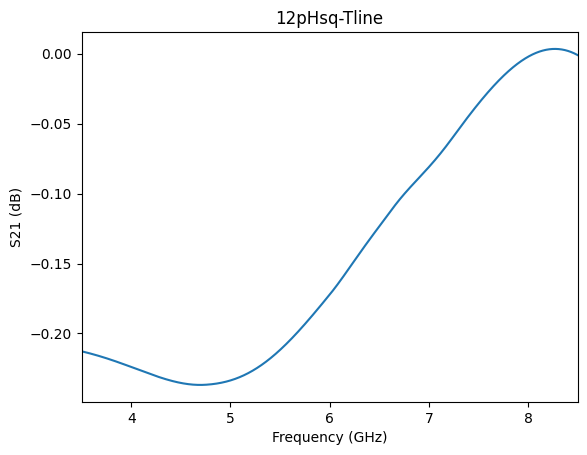

In [16]:
plt.plot(d_12['feedline_thicker_3p5_8p5-v1']['freq']*1e-9,d_12['feedline_thicker_3p5_8p5-v1']['amp'])
plt.title('12pHsq-Tline')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(3.5, 8.5)

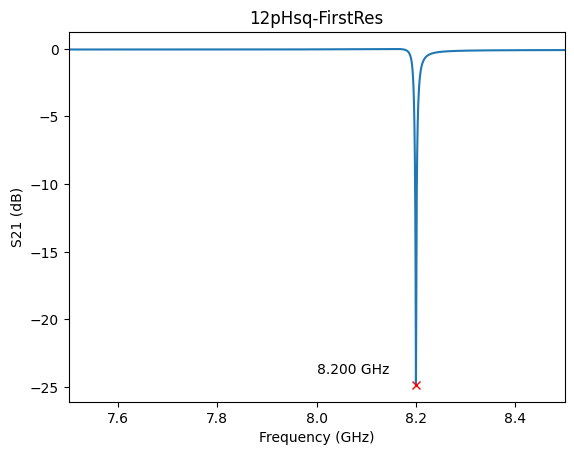

In [30]:
plt.plot(d_12['FistRes12pHsq-v1']['freq']*1e-9,d_12['FistRes12pHsq-v1']['amp'])
plt.title('12pHsq-FirstRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(7.5, 8.5)
peak, _ = sig.find_peaks(-d_12['FistRes12pHsq-v1']['amp'], prominence = 0.1)
f0_first_12 = d_12['FistRes12pHsq-v1']['freq'][peak[0]]
plt.text(8, -24, f'{f0_first_12*1e-9:.3f} GHz')
plt.plot(d_12['FistRes12pHsq-v1']['freq'][peak[0]]*1e-9,d_12['FistRes12pHsq-v1']['amp'][peak[0]], 'rx')

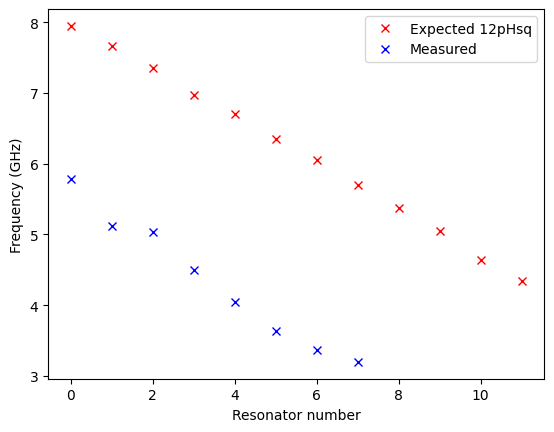

In [193]:
expected_freqs = np.array([7.948403600791222, 7.663150020219628, 7.355747639954814, 6.973531594685684, 6.7006397055111515, 6.351023310370528, 6.049343498641751, 5.69927103744445, 5.376681447598389, 5.0426308975099206, 4.640529736750496, 4.341482501032002])
measured_freqs = 1e-9*np.array([3197586384.122294, 3361346184.317781, 3634948681.0248446, 4041350502.7403507, 4503276783.43186, 5033536374.075741, 5117395659.872908, 5777878232.279747])
plt.plot(range(len(expected_freqs)),expected_freqs, 'rx', label = 'Expected 12pHsq')
plt.plot(range(len(measured_freqs)-1, -1, -1), measured_freqs, 'bx', label = 'Measured')
plt.xlabel('Resonator number')
plt.ylabel('Frequency (GHz)')
plt.legend()


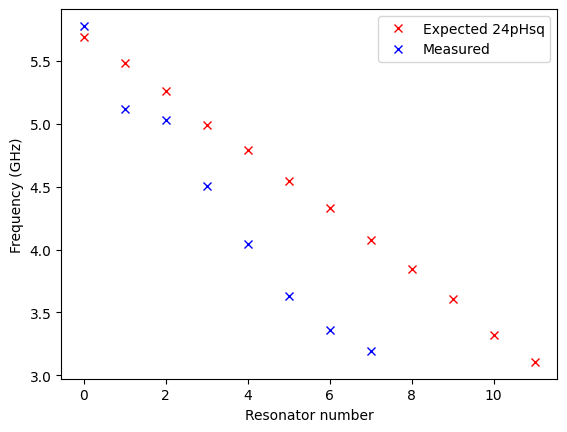

In [194]:
expected_freqs = np.array([5.68852793104255, 5.484359044345681, 5.2643394778823405, 4.990775971549864, 4.795461090188038, 4.545234981442487, 4.329319925145899, 4.078771893385308, 3.847895503046202, 3.6088183583040894, 3.3210403437984324, 3.1070180817204363])
plt.plot(range(len(expected_freqs)),expected_freqs, 'rx', label = 'Expected 24pHsq')
plt.plot(range(len(measured_freqs)-1, -1, -1), measured_freqs, 'bx', label = 'Measured')
plt.xlabel('Resonator number')
plt.ylabel('Frequency (GHz)')
plt.legend()

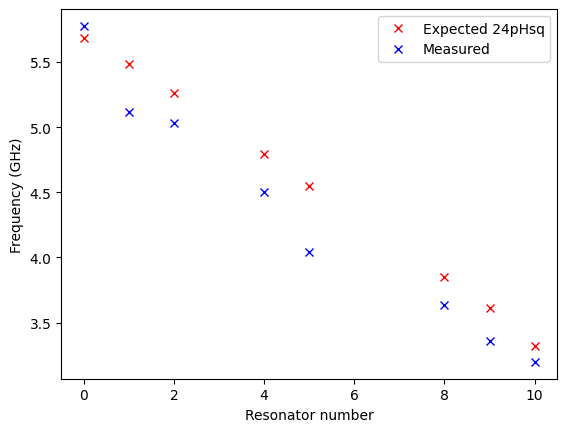

In [203]:
expected_freqs = np.array([5.68852793104255, 5.484359044345681, 5.2643394778823405, 4.990775971549864, 4.795461090188038, 4.545234981442487, 4.329319925145899, 4.078771893385308, 3.847895503046202, 3.6088183583040894, 3.3210403437984324, 3.1070180817204363])
indices = [3,6,7, 11]
expected_freqs = np.delete(expected_freqs, indices)
plt.plot([0,1,2,4,5,8,9,10,],expected_freqs, 'rx', label = 'Expected 24pHsq')

plt.plot([0,1,2,4,5,8,9,10], measured_freqs[::-1], 'bx', label = 'Measured')
plt.xlabel('Resonator number')
plt.ylabel('Frequency (GHz)')
plt.legend()

24pHsq simulations

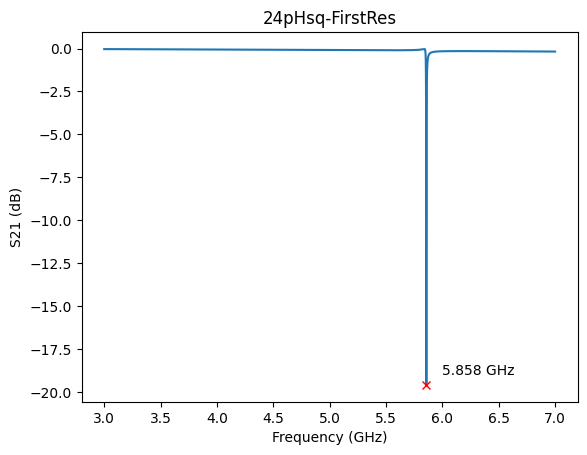

In [188]:
plt.plot(d_12['20240422_SiRes_FirstRes_24pHsq_v1']['freq']*1e-9,d_12['20240422_SiRes_FirstRes_24pHsq_v1']['amp'])
plt.title('24pHsq-FirstRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
# plt.xlim(7.5, 8.5)
peak, _ = sig.find_peaks(-d_12['20240422_SiRes_FirstRes_24pHsq_v1']['amp'], prominence = 0.1)
f0_first_12 = d_12['20240422_SiRes_FirstRes_24pHsq_v1']['freq'][peak[0]]
plt.text(6, -19, f'{f0_first_12*1e-9:.3f} GHz')
plt.plot(d_12['20240422_SiRes_FirstRes_24pHsq_v1']['freq'][peak[0]]*1e-9,d_12['20240422_SiRes_FirstRes_24pHsq_v1']['amp'][peak[0]], 'rx')

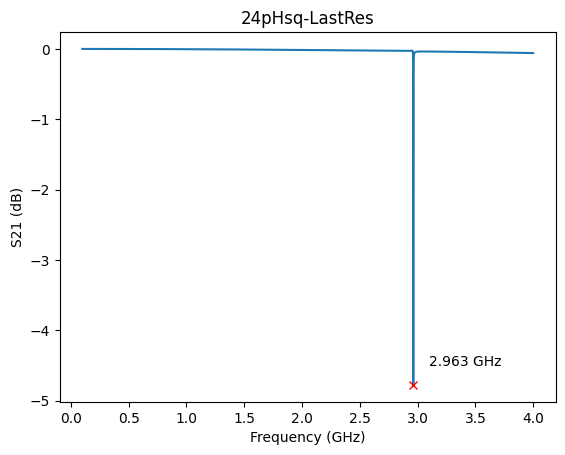

In [192]:
plt.plot(d_12['20240422_SiRes_LastRes_24pHsq_v1']['freq']*1e-9,d_12['20240422_SiRes_LastRes_24pHsq_v1']['amp'])
plt.title('24pHsq-LastRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
# plt.xlim(7.5, 8.5)
peak, _ = sig.find_peaks(-d_12['20240422_SiRes_LastRes_24pHsq_v1']['amp'], prominence = 0.1)
f0_last_12 = d_12['20240422_SiRes_LastRes_24pHsq_v1']['freq'][peak[0]]
plt.text(3.1, -4.5, f'{f0_last_12*1e-9:.3f} GHz')
plt.plot(d_12['20240422_SiRes_LastRes_24pHsq_v1']['freq'][peak[0]]*1e-9,d_12['20240422_SiRes_LastRes_24pHsq_v1']['amp'][peak[0]], 'rx')

Fitting

In [59]:
Qe_first_12 = Qe_from_S21(d_12['FistRes12pHsq-v1']['amp'], d_12['FistRes12pHsq-v1']['freq']*2*np.pi, 0.1)
Z_first_12 = impedance_resonator_from_S21(d_12['FistRes12pHsq-v1']['amp'], 50)
Cc_first_12 = 1/(Z_first_12[0]*2*np.pi*d_12['FistRes12pHsq-v1']['freq'][0])
print(f'Qe = {Qe_first_12:.0f}')
print(f'Cc = {Cc_first_12*1e15}fF')
C0_first_12 = 50*Qe_first_12*f0*2*np.pi*Cc_first_12**2-Cc_first_12
print(f'C0 = {C0_first_12*1e15}fF')


Qe = 1224
Cc = 4.910711793025206fF
C0 = 71.12787498874054fF


In [163]:
Cr_first, Lg_first, Cc_first, f0_first, Qc_first = get_resonator_parameters(f0_first_12, Qe_first_12, Lk = 12e-12, length_ind = 501e-6, width_ind = 0.6e-6,  Cr = 37.9e-15, Lg = 0.5e-9, Cc = 1e-15)
print(f'Cr = {Cr_first*1e15:.2f} fF')
print(f'Lg = {Lg_first*1e9:.2f} nH')
print(f'Cc = {Cc_first*1e15:.2f} fF')
print(f'f0 = {f0_first*1e-9:.3f} GHz')
print(f'Qc = {Qc_first:.0f}')

Cr = 31.84 fF
Lg = 0.69 nH
Cc = 3.34 fF
f0 = 8.200 GHz
Qc = 1224


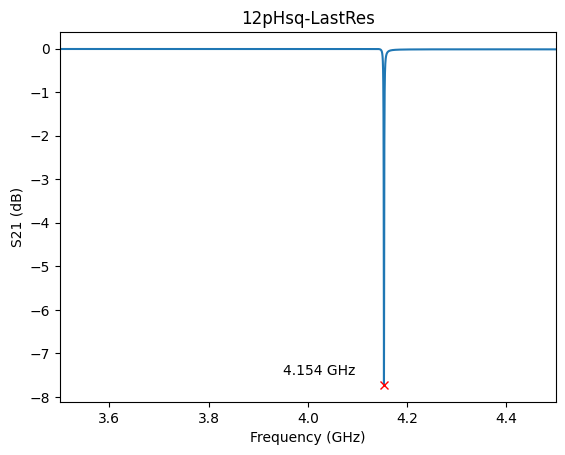

In [32]:
plt.plot(d_12['LastRes-12pHsq-v1']['freq']*1e-9,d_12['LastRes-12pHsq-v1']['amp'])
plt.title('12pHsq-LastRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(3.5, 4.5)
peak, _ = sig.find_peaks(-d_12['LastRes-12pHsq-v1']['amp'], prominence = 0.1)
f0_last_12 = d_12['LastRes-12pHsq-v1']['freq'][peak[0]]
plt.text(3.95, -7.5, f'{f0_last_12*1e-9:.3f} GHz')
plt.plot(d_12['LastRes-12pHsq-v1']['freq'][peak[0]]*1e-9,d_12['LastRes-12pHsq-v1']['amp'][peak[0]], 'rx')




In [75]:
Qe_last_12 = Qe_from_S21(d_12['LastRes-12pHsq-v1']['amp'], d_12['LastRes-12pHsq-v1']['freq']*2*np.pi, 0.1)
Z_last_12 = impedance_resonator_from_S21(d_12['LastRes-12pHsq-v1']['amp'], 50)
Cc_last_12 = 1/(Z_last_12[0]*2*np.pi*d_12['LastRes-12pHsq-v1']['freq'][0])
print(f'Qe = {Qe_last_12:.0f}')
print(f'Cc = {Cc_last_12*1e15}fF')
C0_last_12 = 50*Qe_last_12*f0*2*np.pi*Cc_last_12**2-Cc_last_12
print(f'C0 = {C0_last_12*1e15}fF')

Qe = 3461
Cc = 2.3074868176190053fF
C0 = 45.172084774628495fF


In [126]:
1e9*12e-12*1680e-6/0.6e-6

33.6

In [173]:
Cr_last, Lg_last, Cc_last, f0_last, Qc_last = get_resonator_parameters(f0_last_12, Qe_last_12, Lk = 12e-12, length_ind = 1680e-6, width_ind = 0.6e-6,  Cr = 37.7e-15, Lg = 1.67e-9, Cc = 3e-15)
print(f'Cr = {Cr_last*1e15:.2f}fF')
print(f'Lg = {Lg_last*1e9:.2f}nH')
print(f'Cc = {Cc_last*1e15:.2f}fF')
print(f'f0 = {f0_last*1e-9:.3f}GHz')
print(f'Qc = {Qc_last:.0f}')

Cr = 38.55fF
Lg = 1.71nH
Cc = 3.03fF
f0 = 4.154GHz
Qc = 3461


# 24pHsq

In [27]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240610-SiRes-24pHsq-v1'
file_list = os.listdir(path)
print(file_list)
d_24 = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_24[name] = {'freq': freq, 'amp': amp}
    

['24pHsq-FirstRes.mat', '24pHsq-LastRes.mat', '24pHsq-Tline.mat']


Text(0.5, 1.0, '24pHsq-Tline')

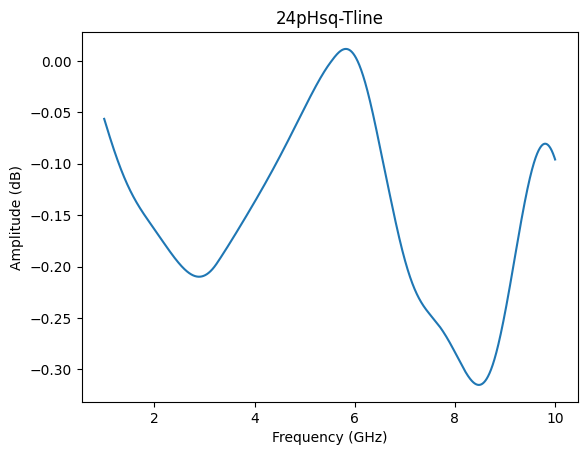

In [28]:
plt.plot(1e-9*d_24['24pHsq-Tline']['freq'], d_24['24pHsq-Tline']['amp'])
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-Tline')

Text(0.5, 1.0, '24pHsq-FirstRes')

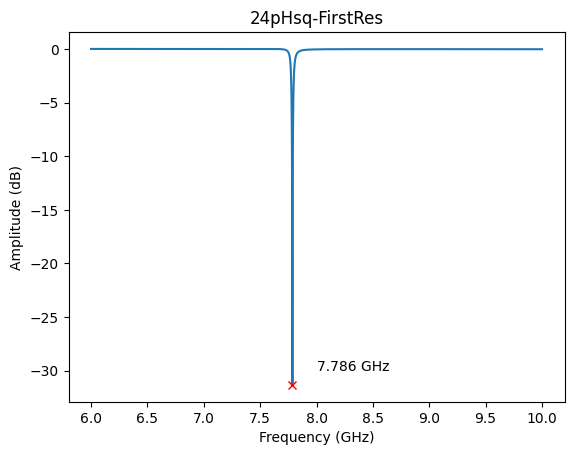

In [10]:
plt.plot(1e-9*d_24['24pHsq-FirstRes']['freq'], d_24['24pHsq-FirstRes']['amp'])
peak, _ = sig.find_peaks(-d_24['24pHsq-FirstRes']['amp'], prominence = 0.1)
f0 = d_24['24pHsq-FirstRes']['freq'][peak[0]]
plt.text(8, -30, f'{f0*1e-9:.3f} GHz')
plt.plot(d_24['24pHsq-FirstRes']['freq'][peak[0]]*1e-9,d_24['24pHsq-FirstRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-FirstRes')

Text(0.5, 1.0, '24pHsq-LastRes')

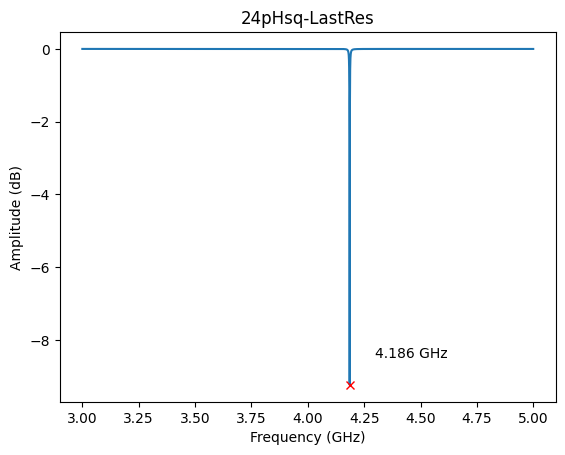

In [13]:
plt.plot(1e-9*d_24['24pHsq-LastRes']['freq'], d_24['24pHsq-LastRes']['amp'])
peak, _ = sig.find_peaks(-d_24['24pHsq-LastRes']['amp'], prominence = 0.1)
f0 = d_24['24pHsq-LastRes']['freq'][peak[0]]
plt.text(4.3, -8.5, f'{f0*1e-9:.3f} GHz')
plt.plot(d_24['24pHsq-LastRes']['freq'][peak[0]]*1e-9,d_24['24pHsq-LastRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-LastRes')

# 61 pH/sq

In [25]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240610-GeRes-61pHsq-v1'
file_list = os.listdir(path)
print(file_list)
d_61 = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_61[name] = {'freq': freq, 'amp': amp}
    

['61pHsq-FirstRes-Si.mat', '61pHsq-FirstRes.mat', '61pHsq-LastRes-Si-12pHsq.mat', '61pHsq-LastRes-Si.mat', '61pHsq-LastRes.mat', '61pHsq-Tline.mat']


Text(0.5, 1.0, '61pHsq-Tline')

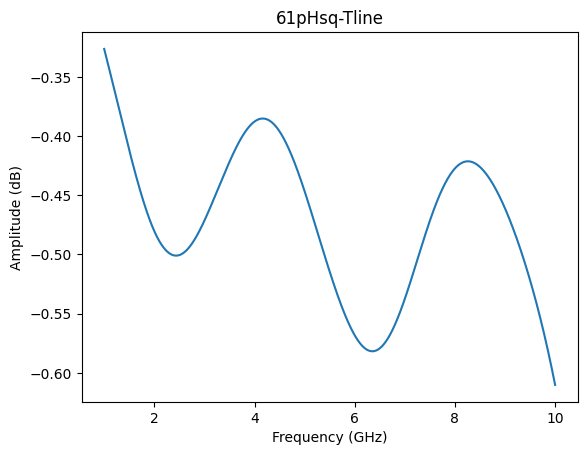

In [26]:
plt.plot(1e-9*d_61['61pHsq-Tline']['freq'], d_61['61pHsq-Tline']['amp'])
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-Tline')

Text(0.5, 1.0, '61pHsq-FirstRes')

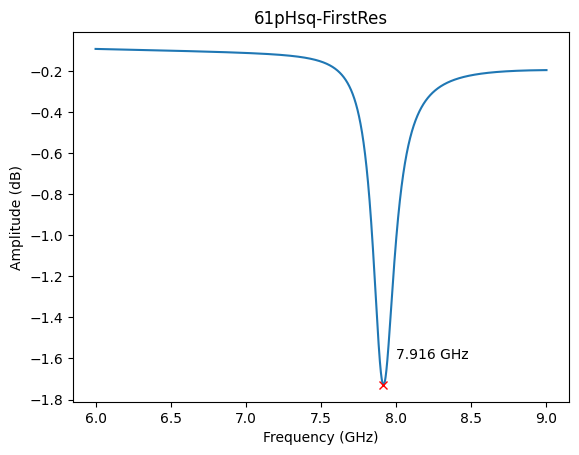

In [8]:
plt.plot(1e-9*d_61['61pHsq-FirstRes']['freq'], d_61['61pHsq-FirstRes']['amp'])
peak, _ = sig.find_peaks(-d_61['61pHsq-FirstRes']['amp'], prominence = 0.1)
f0 = d_61['61pHsq-FirstRes']['freq'][peak[0]]
plt.text(8, -1.6, f'{f0*1e-9:.3f} GHz')
plt.plot(d_61['61pHsq-FirstRes']['freq'][peak[0]]*1e-9,d_61['61pHsq-FirstRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-FirstRes')


Text(0.5, 1.0, '61pHsq-FirstRes-Si')

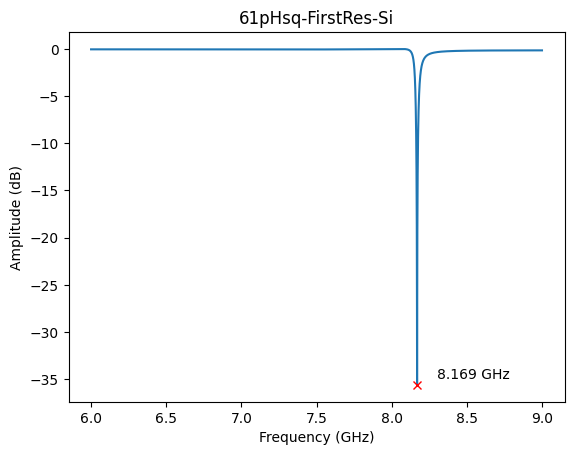

In [14]:
plt.plot(1e-9*d_61['61pHsq-FirstRes-Si']['freq'], d_61['61pHsq-FirstRes-Si']['amp'])
peak, _ = sig.find_peaks(-d_61['61pHsq-FirstRes-Si']['amp'], prominence = 0.1)
f0 = d_61['61pHsq-FirstRes-Si']['freq'][peak[0]]
plt.text(8.3, -35, f'{f0*1e-9:.3f} GHz')
plt.plot(d_61['61pHsq-FirstRes-Si']['freq'][peak[0]]*1e-9,d_61['61pHsq-FirstRes-Si']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-FirstRes-Si')


Text(0.5, 1.0, '61pHsq-LastRes')

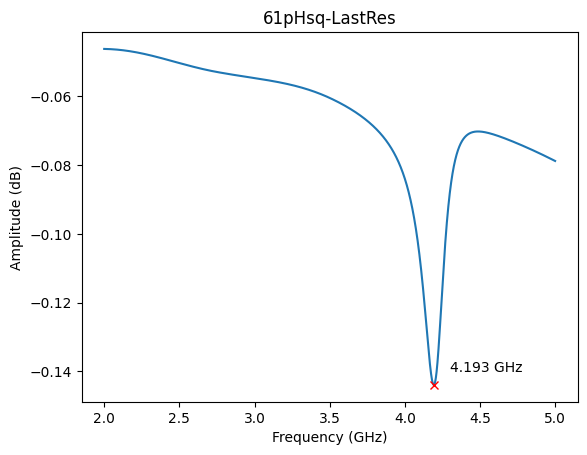

In [11]:
plt.plot(1e-9*d_61['61pHsq-LastRes']['freq'], d_61['61pHsq-LastRes']['amp'])
peak, _ = sig.find_peaks(-d_61['61pHsq-LastRes']['amp'], prominence = 0.01)
f0 = d_61['61pHsq-LastRes']['freq'][peak[0]]
plt.text(4.3, -0.14, f'{f0*1e-9:.3f} GHz')
plt.plot(d_61['61pHsq-LastRes']['freq'][peak[0]]*1e-9,d_61['61pHsq-LastRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-LastRes')


Text(0.5, 1.0, '61pHsq-LastRes-Si')

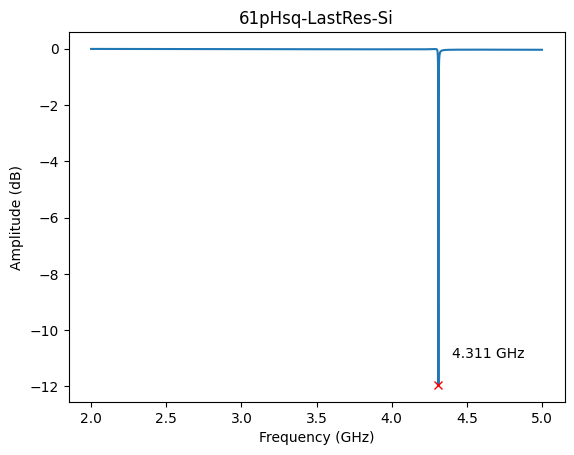

In [17]:
plt.plot(1e-9*d_61['61pHsq-LastRes-Si']['freq'], d_61['61pHsq-LastRes-Si']['amp'])
peak, _ = sig.find_peaks(-d_61['61pHsq-LastRes-Si']['amp'], prominence = 0.1)
f0 = d_61['61pHsq-LastRes-Si']['freq'][peak[0]]
plt.text(4.4, -11, f'{f0*1e-9:.3f} GHz')
plt.plot(d_61['61pHsq-LastRes-Si']['freq'][peak[0]]*1e-9,d_61['61pHsq-LastRes-Si']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-LastRes-Si')


Text(0.5, 1.0, '61pHsq-LastRes-Si-12pHsq')

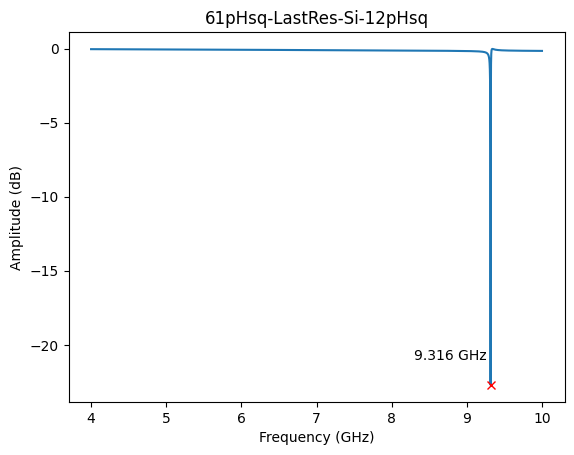

In [21]:
plt.plot(1e-9*d_61['61pHsq-LastRes-Si-12pHsq']['freq'], d_61['61pHsq-LastRes-Si-12pHsq']['amp'])
peak, _ = sig.find_peaks(-d_61['61pHsq-LastRes-Si-12pHsq']['amp'], prominence = 0.1)
f0 = d_61['61pHsq-LastRes-Si-12pHsq']['freq'][peak[0]]
plt.text(8.3, -21, f'{f0*1e-9:.3f} GHz')
plt.plot(d_61['61pHsq-LastRes-Si-12pHsq']['freq'][peak[0]]*1e-9,d_61['61pHsq-LastRes-Si-12pHsq']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('61pHsq-LastRes-Si-12pHsq')

# Pt annealed test

In [5]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240717-GeRes-Pt-61pHsq-v1'
file_list = os.listdir(path)
print(file_list)
d_61_Pt = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_61_Pt[name] = {'freq': freq, 'amp': amp}
    

['20240717_12GHz_Pt_61pHsq-1.mat', '20240717_12GHz_Pt_61pHsq-2.mat', '20240717_12GHz_Pt_61pHsq.mat', '20240717_17GHz_Pt_61pHsq-1.mat', '20240717_17GHz_Pt_61pHsq.mat', '20240717_1GHz_Pt_61pHsq.mat', '20240717_30GHz_Pt_61pHsq.mat', '20240717_4GHz_Pt_61pHsq.mat', '20240717_4p3GHz_Pt_61pHsq.mat', '20240717_8GHz_Pt_61pHsq-1.mat', '20240717_8GHz_Pt_61pHsq-2.mat', '20240717_8GHz_Pt_61pHsq.mat']


In [ ]:
for name in d_61_Pt.keys():
    plt.plot(1e-9*d_61_Pt[name]['freq'], d_61_Pt[name]['amp'])
    peak, _ = sig.find_peaks(-d_61_Pt[name]['amp'], prominence = 1)
    plt.plot(d_61_Pt[name]['freq'][peak[0]]*1e-9,d_61_Pt[name]['amp'][peak[0]], 'rx')
    plt.title(name)
    plt.show()
    plt.close()

Text(0.5, 1.0, '61pHsq-Pt-Resonators')

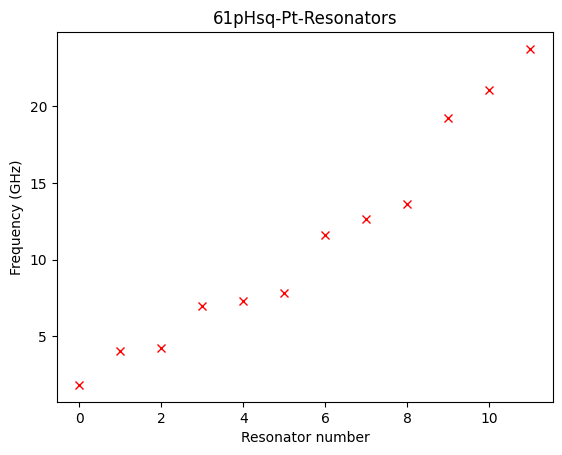

In [18]:
f0_list = []
for name in d_61_Pt.keys():
    peak, _ = sig.find_peaks(-d_61_Pt[name]['amp'], prominence = 1)
    f0 = 1e-9*d_61_Pt[name]['freq'][peak[0]]
    f0_list.append(f0)

f0_list.sort()
plt.plot( f0_list, 'rx')
plt.xlabel('Resonator number')
plt.ylabel('Frequency (GHz)')
plt.title('61pHsq-Pt-Resonators')


# Pt via test

In [6]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\Pt-via-test'
file_list = os.listdir(path)
print(file_list)
d_via = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_via[name] = {'freq': freq, 'amp': amp}

['20240717_1GHz_Pt_61pHsq.mat', 'Pt-via-test-1GHz-12pHsq.mat', 'Pt-via-test-1GHz-13p5pHsq.mat', 'Pt-via-test-1GHz-15pHsq.mat', 'Pt-via-test-1GHz-30pHsq.mat', 'Pt-via-test-1GHz-61pHsq.mat']


(-2.0, 0.1)

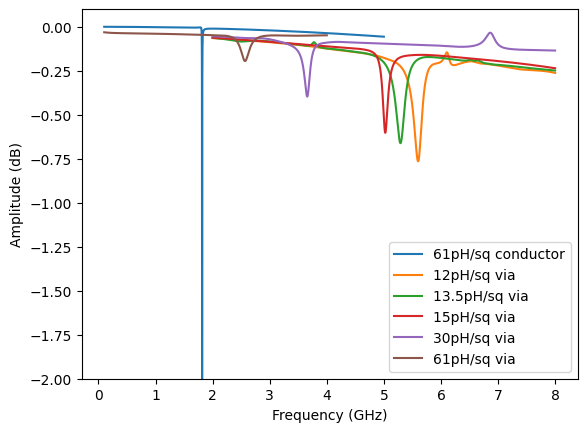

In [9]:
Lk = ['61pH/sq conductor', '12pH/sq via', '13.5pH/sq via','15pH/sq via', '30pH/sq via', '61pH/sq via' ]

for i, name in enumerate(d_via.keys()):

    plt.plot(1e-9*d_via[name]['freq'], d_via[name]['amp'], label = Lk[i])

plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.ylim(-2, 0.1)

20240717_1GHz_Pt_61pHsq f0 = 1.815 GHz
Pt-via-test-1GHz-12pHsq f0 = 5.599 GHz
Pt-via-test-1GHz-13p5pHsq f0 = 5.291 GHz
Pt-via-test-1GHz-15pHsq f0 = 5.024 GHz
Pt-via-test-1GHz-30pHsq f0 = 3.657 GHz
Pt-via-test-1GHz-61pHsq f0 = 2.567 GHz


Text(0, 0.5, 'Frequency (GHz)')

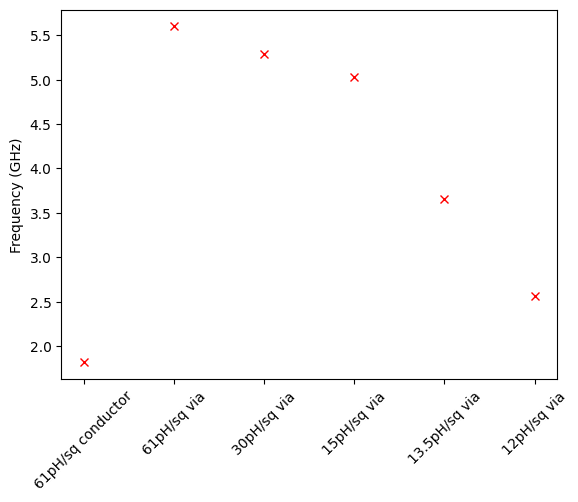

In [14]:
for i, name in enumerate(d_via.keys()):
    peak, _ = sig.find_peaks(-d_via[name]['amp'], prominence = 0.1)
    f0 = 1e-9*d_via[name]['freq'][peak[0]]
    print(f'{name} f0 = {f0:.3f} GHz')
    plt.plot(i, f0, 'rx')
    plt.xticks(range(len(d_via.keys())), Lk, rotation = 45)
plt.ylabel('Frequency (GHz)')

# Anneal Pt cap sim

['Al-on-Si.csv', 'NoQW.csv', 'Pt-inside.csv', 'Pt-on-Si.csv', 'Pt-on-top-thicken.csv', 'Pt-on-top.csv', 'Pt-substract-SiGe.csv']
[252.23952245 252.23952245 239.42680084 240.82481693 229.02325383
 219.73167199 219.83767818]


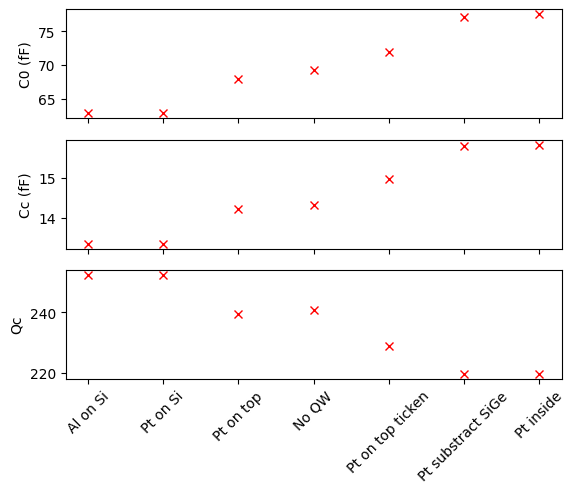

In [32]:
import csv
path = r'C:\Users\localadmin\Documents\Ansoft\Anneal-Pt-test'
file_list_all = os.listdir(path)
file_list = []
for f in file_list_all:
    if f.endswith('.csv'):
        file_list.append(f)
print(file_list)

C0 = []
Cc = []
for f in file_list:
    with open(os.path.join(path, f), mode ='r') as file:
        csvFile = csv.reader(file)
        for i, row in enumerate(csvFile):
            if i == 0:
                pass
            if i == 1:
                C0.append(float(row[1]))
                Cc.append(float(row[2]))
C0 = np.sort(-1*np.array(C0))
Cc = np.sort(-1*np.array(Cc)) 
fig, ax = plt.subplots(3,1)
ax[0].plot(C0, 'rx')
ax[0].set_ylabel('C0 (fF)')
ax[1].plot(Cc, 'rx')
ax[1].set_ylabel('Cc (fF)')
ax[0].set_xticks(ticks = range(len(C0)), labels = [])
ax[1].set_xticks(ticks = range(len(C0)), labels = [])

# ax[1].set_xticks(ticks = range(len(C0)), labels = ['No QW', 'Pt inside', 'Pt on top', 'Pt substract SiGe'])

fr = 5.4e9
Qc = 1e15*(Cc + C0)/(2*np.pi*fr*50*Cc**2)
print(Qc)
ax[2].plot(Qc, 'rx')
ax[2].set_ylabel('Qc')
ax[2].set_xticks(ticks = range(len(C0)), labels =  ['Al on Si', 'Pt on Si', 'Pt on top',  'No QW',  'Pt on top ticken',    'Pt substract SiGe',  'Pt inside',   ], rotation = 45)

# 


In [9]:
Qi = 100
Ql = 1/(1/Qc + 1/Qi)
print(Ql)

[70.65941357 68.73414021 69.60701141 68.7237741 ]


# 2024-05-SiRes12pH-v1 cap

['C0.csv', 'Cc.csv']
[ 540.37331977  570.28166835  604.37272351  778.02356915  626.55636028
 1094.76770201  678.88116222 2644.82332672  752.55593675 2289.81776355
  834.84666436]


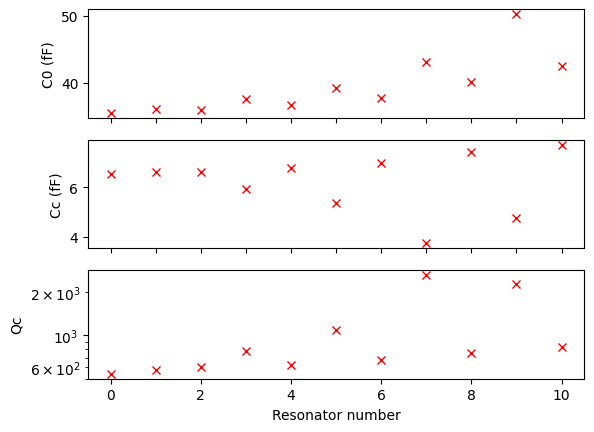

In [26]:
path = r'C:\Users\localadmin\Documents\Ansoft\202405-SiRes-12pHsq-v1'
file_list_all = os.listdir(path)
file_list = []
for f in file_list_all:
    if f.endswith('.csv'):
        file_list.append(f)
print(file_list)

C0 = []
Cc = []
for j,f in enumerate(file_list):
    with open(os.path.join(path, f), mode ='r') as file:
        csvFile = csv.reader(file)
        for i, row in enumerate(csvFile):
            if i == 0:
                pass
            elif i == 1 and j ==0:
                C0 = row[1:]
            else:
                Cc = row[1:]
#                 Cc.append(float(row[2]))
for i in range(len(C0)):
    C0[i] = float(C0[i])
    Cc[i] = float(Cc[i])


C0 = -1*np.array(C0)
Cc = -1*np.array(Cc) 

fig, ax = plt.subplots(3,1)
ax[0].plot(C0, 'rx')
ax[0].set_ylabel('C0 (fF)')
ax[1].plot(Cc, 'rx')
ax[1].set_ylabel('Cc (fF)')
fr = 1e9*np.array([3.197816 ,  3.36209 ,  3.635356 ,  4.043814 , 4.3,  4.504934 ,4.8,  5.031816 , 5.115394 , 5.4, 5.777206])
fr = fr[::-1]
Qc = 1e15*(Cc + C0)/(2*np.pi*fr*50*Cc**2)
print(Qc)
ax[2].semilogy(Qc, 'rx')
ax[2].set_ylabel('Qc')
ax[2].set_xlabel('Resonator number')
ax[0].set_xticks(ticks = range(len(C0)), labels = [])
ax[1].set_xticks(ticks = range(len(C0)), labels = [])
